In [1]:
%pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Weights and Bias to version the dataset
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import warnings
warnings.filterwarnings("ignore")

In [5]:
import wandb

In [6]:
wandb.login()

wandb: Currently logged in as: alokpadhi. Use `wandb login --relogin` to force relogin


True

In [7]:
# get label_encoder.json file from wandb
# run = wandb.init()
# artifact = run.use_artifact('alokpadhi/stackoverflow-quality/data_artifacts:v0', type='preprcossing_data')
# artifact_dir = artifact.download()

In [8]:
from pathlib import Path

In [16]:
Path("../../datasets/preprocessed").mkdir(exist_ok=True)

In [17]:
preprocessed_datapath = Path("../../datasets/preprocessed")

In [21]:
# # Get preprocessed data
# run = wandb.init()
# artifact = run.use_artifact('alokpadhi/stackoverflow-quality/processed_dataset:v1', type='raw_data')
# artifact_dir = artifact.download(preprocessed_datapath)

In [24]:
df = pd.read_parquet('../../datasets/preprocessed/train_processed.parquet')

In [25]:
df.head()

,Y,text
0,LQ_CLOSE,java repeat task every random seconds already ...
1,HQ,java optionals immutable like understand java ...
2,HQ,text overlay image darkened opacity react nati...
3,HQ,ternary operator swift picky question simple c...
4,HQ,hide show fab scale animation using custom flo...


In [26]:
# Feature and target
X = df.text.to_numpy()
y = df.Y

In [27]:
import json

In [28]:
# Label encoder to encode class labels
class LabelEncoder(object):
    """Encode labels into unqiue ids/integers"""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        
    def __len__(self):
        return len(self.class_to_index)
    
    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"
    
    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self
    
    def encode(self, y):
        encoded = np.zeros(len(y), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded
    
    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
            
        return classes
    
    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)
    
    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [30]:
label_encoder = LabelEncoder.load("../../artifacts/label_encoder.json")

In [31]:
label_encoder.class_to_index

{'HQ': 0, 'LQ_CLOSE': 1, 'LQ_EDIT': 2}

In [32]:
NUM_CLASSES = len(label_encoder)

In [33]:
# Encode all our labels
y = label_encoder.encode(y)
print(y.shape)

(45000,)


In [34]:
from sklearn.model_selection import train_test_split

In [35]:
# split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

In [36]:
# To ensure the target distribution remains same across the splits
X_train, X_, y_train, y_ = train_test_split(
                            X, y, train_size=train_size, stratify=y)

In [37]:
print(f"train: {len(X_train)} ({(len(X_train)/len(X)):.2f})\n"
     f"remaining: {len(X_)} ({(len(X_)/len(X)):.2f})")

train: 31499 (0.70)
remaining: 13501 (0.30)


In [38]:
# split for validation and test set
X_val, X_test, y_val, y_test = train_test_split(
                                X_, y_, train_size=0.5, stratify=y_)

In [39]:
print(f"train: {len(X_train)} ({(len(X_train)/len(X)):.2f})\n"
     f"val: {len(X_val)} ({(len(X_val)/len(X)):.2f})\n"
     f"test: {len(X_test)} ({(len(X_test)/len(X)):.2f})")

train: 31499 (0.70)
val: 6750 (0.15)
test: 6751 (0.15)


In [40]:
# Get counts for each class
counts = {}
counts["train_counts"] = {rating: label_encoder.decode(y_train).count(rating) for rating in label_encoder.classes}
counts["val_counts"] = {rating: label_encoder.decode(y_val).count(rating) for rating in label_encoder.classes}
counts["test_counts"] = {rating: label_encoder.decode(y_test).count(rating) for rating in label_encoder.classes}

In [43]:
# convert the class distribution across splits to dataframe
dist_df = pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)
dist_df

,HQ,LQ_CLOSE,LQ_EDIT
train,10499,10500,10500
val,2250,2250,2250
test,2251,2250,2250


In [45]:
train_df = pd.DataFrame({"text": X_train, "rating": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "rating": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "rating": label_encoder.decode(y_test)})

In [47]:
# check train
train_df.head(10)

,text,rating
0,python wrong codepython beginner trying execut...,LQ_EDIT
1,map json object array list javascript hi json ...,LQ_CLOSE
2,order stl queue container trying make queue cl...,LQ_CLOSE
3,traverse website get console say website follo...,LQ_CLOSE
4,preg match all get something preg match all( d...,LQ_EDIT
5,media query switch 768 resize window pre code ...,LQ_CLOSE
6,enable html button certain delay display count...,LQ_CLOSE
7,finding difference 2 strings 2 texboxes powerp...,LQ_CLOSE
8,program run properly wrote program reason else...,LQ_CLOSE
9,domain configuration docker compose configure ...,HQ


<AxesSubplot:xlabel='rating', ylabel='count'>

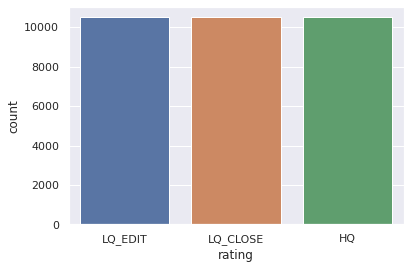

In [48]:
# plot train rating distribution
sns.countplot(train_df['rating'])

In [49]:
from pathlib import Path

In [51]:
dataset_path = Path("../../datasets/V1").mkdir(exist_ok=True)

In [56]:
dataset_path = Path("../../datasets/V1")

In [58]:
train_df.to_parquet(dataset_path / "train.parquet",index=False)
val_df.to_parquet(dataset_path / "valid.parquet",index=False)
test_df.to_parquet(dataset_path / "test.parquet",index=False)

In [61]:
# dataset version for v1
v1_run = wandb.init(project="stackoverflow-quality", name="Model training data")
datav1 = wandb.Artifact("Training-dataset", type="raw_data", description="Train, Val and test splits", metadata={"train_size": len(train_df), "val_size": len(val_df),
                                                                                                            "test_size": len(test_df)})
datav1.add_dir(dataset_path)
    
v1_run.log_artifact(datav1)

wandb: Adding directory to artifact (./../../datasets/V1)... Done. 0.0s
